In [1]:
import pandas as pd
import numpy as np
import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

We start by loading the data and setting the index column. We then find the number of observations to be 450.

In [2]:
data = pd.read_csv('project1_data.csv', delimiter=';', index_col='id')

In [3]:
data.head()

,weight,height,sex,cats,age,income,savings,single,place,expenses
id,,,,,,,,,,
1,84.99,171.72,1,2,55,1213.10,480.45,0,1,326.33
2,91.06,175.83,1,2,41,1300.14,192.14,0,2,409.24
3,88.30,175.34,1,1,42,1203.19,643.34,0,3,274.26
4,84.51,167.64,1,1,50,1231.13,303.35,0,1,374.86
5,85.72,171.62,1,2,53,892.02,424.99,0,2,248.24


In [4]:
data.describe()

,weight,height,sex,cats,age,income,savings,single,place,expenses
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,89.477667,177.277267,1.488889,2.035556,50.613333,1592.097733,620.030667,0.364444,2.046667,308.810178
std,3.600803,7.918122,0.500433,1.372195,6.847808,940.605357,415.998130,0.481810,0.721944,126.167312
min,77.890000,158.670000,1.000000,0.000000,34.000000,691.730000,85.800000,0.000000,1.000000,-391.650000
25%,86.830000,170.755000,1.000000,1.000000,46.000000,1051.787500,387.605000,0.000000,2.000000,236.567500
50%,89.420000,176.635000,1.000000,2.000000,51.000000,1281.810000,560.415000,0.000000,2.000000,336.990000
75%,92.030000,183.935000,2.000000,3.000000,55.000000,1799.727500,733.565000,1.000000,3.000000,407.227500
max,99.720000,195.790000,2.000000,5.000000,73.000000,7089.020000,3200.920000,1.000000,3.000000,486.790000


We then divide the columns into quantitative and qualitative. The latter ones are sex, single and place. The sex and single columns have two possible values indicating whether a person is a female/lives alone. The place variable describes where the person lives and the values are not indicating anything more than that.

In [5]:
quantitative_cols = [
    'weight',
    'height',
    'cats',
    'age',
    'income',
    'savings',
    'expenses'
]
qualitative_cols = [
    'sex',
    'single',
    'place'
]

We do not have any missing values.

In [6]:
data.isna().sum()

weight      0
height      0
sex         0
cats        0
age         0
income      0
savings     0
single      0
place       0
expenses    0
dtype: int64

In [7]:
data[quantitative_cols].describe()

,weight,height,cats,age,income,savings,expenses
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,89.477667,177.277267,2.035556,50.613333,1592.097733,620.030667,308.810178
std,3.600803,7.918122,1.372195,6.847808,940.605357,415.998130,126.167312
min,77.890000,158.670000,0.000000,34.000000,691.730000,85.800000,-391.650000
25%,86.830000,170.755000,1.000000,46.000000,1051.787500,387.605000,236.567500
50%,89.420000,176.635000,2.000000,51.000000,1281.810000,560.415000,336.990000
75%,92.030000,183.935000,3.000000,55.000000,1799.727500,733.565000,407.227500
max,99.720000,195.790000,5.000000,73.000000,7089.020000,3200.920000,486.790000


In [8]:
for col in qualitative_cols:
    display(data[col].value_counts())

sex
1    230
2    220
Name: count, dtype: int64

single
0    286
1    164
Name: count, dtype: int64

place
2    215
3    128
1    107
Name: count, dtype: int64

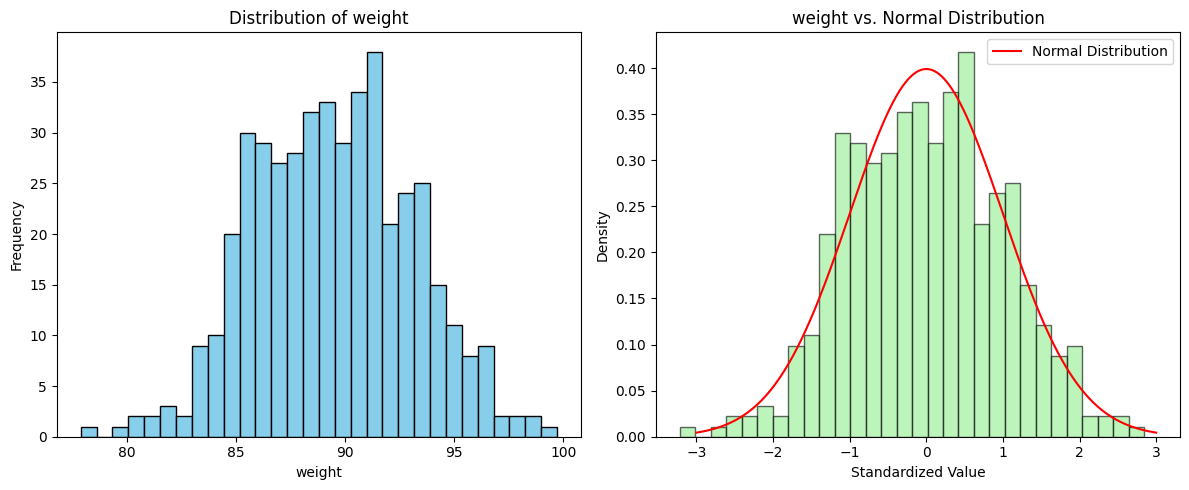

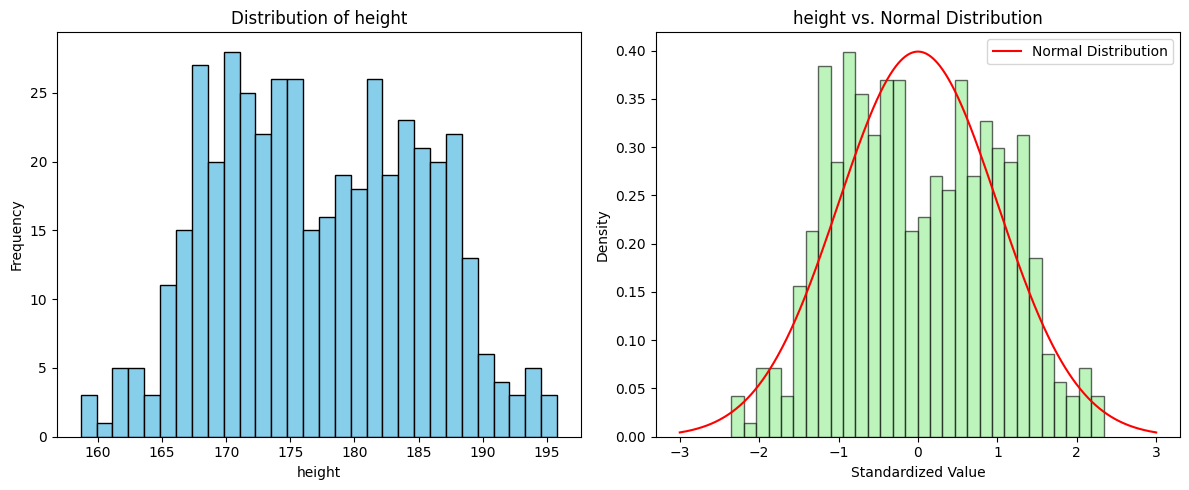

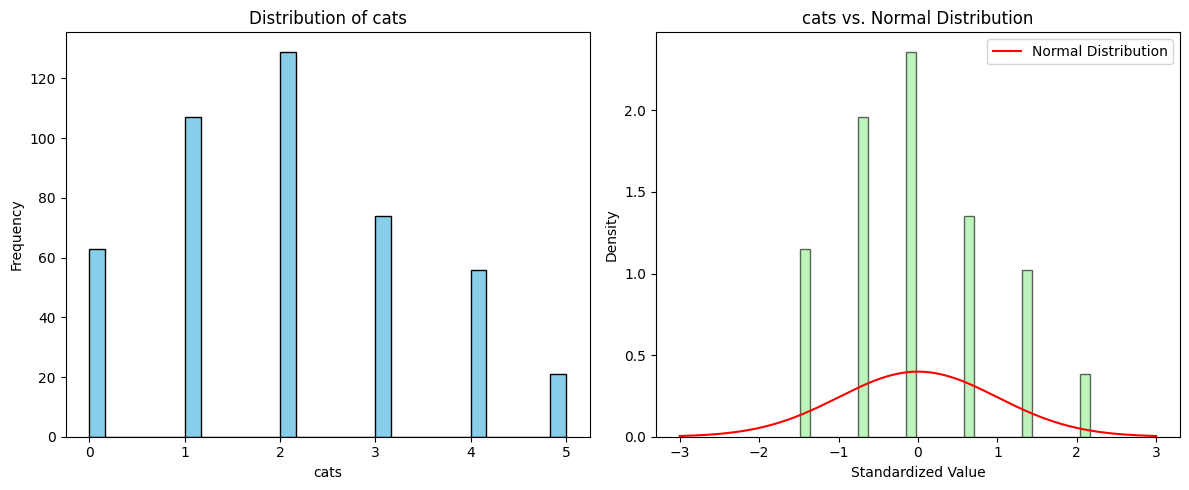

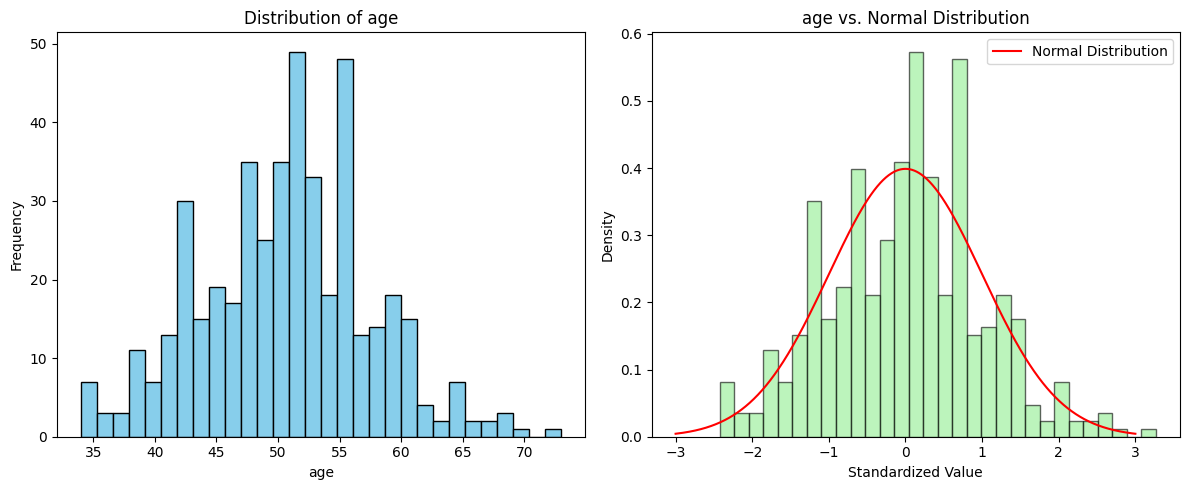

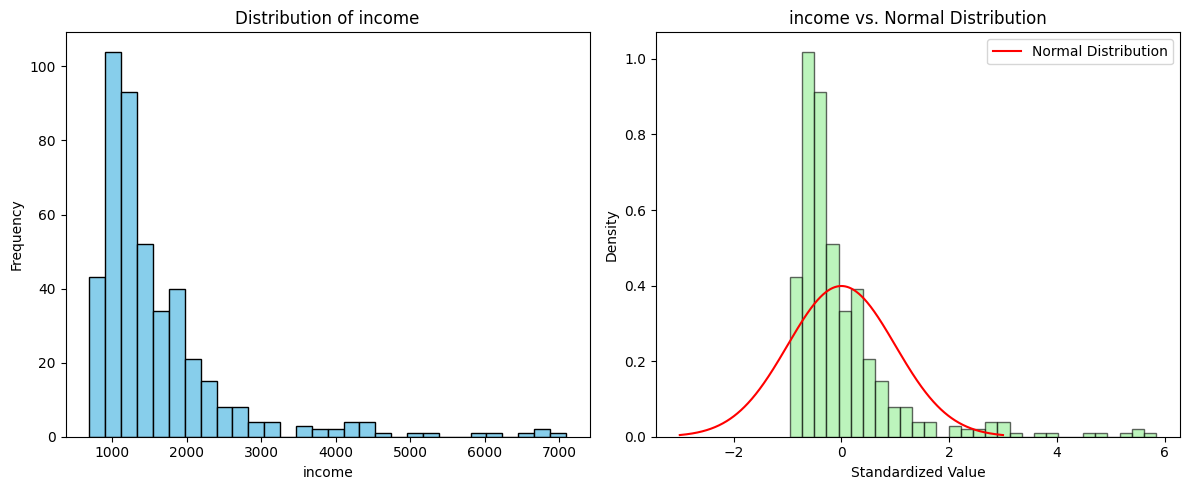

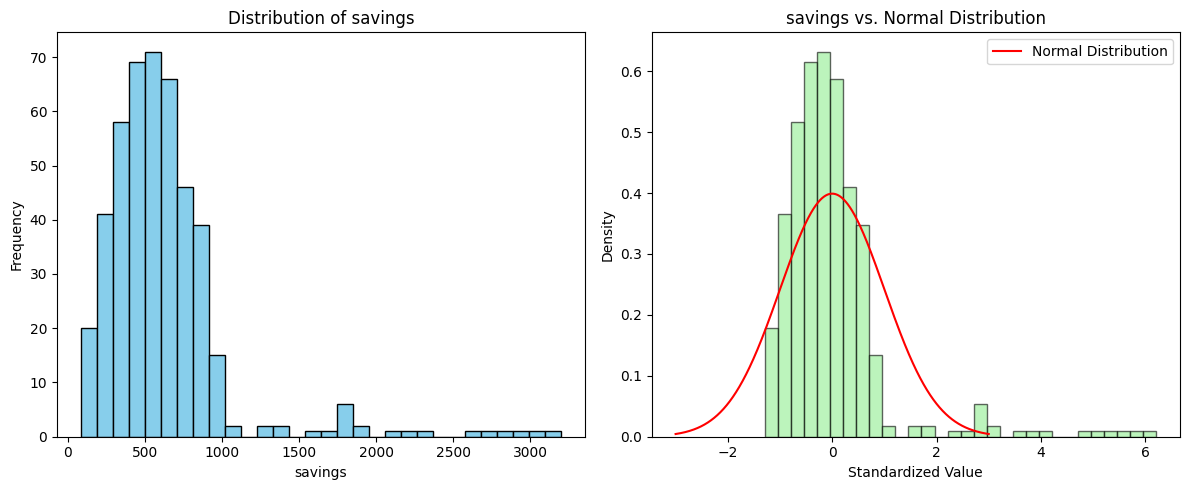

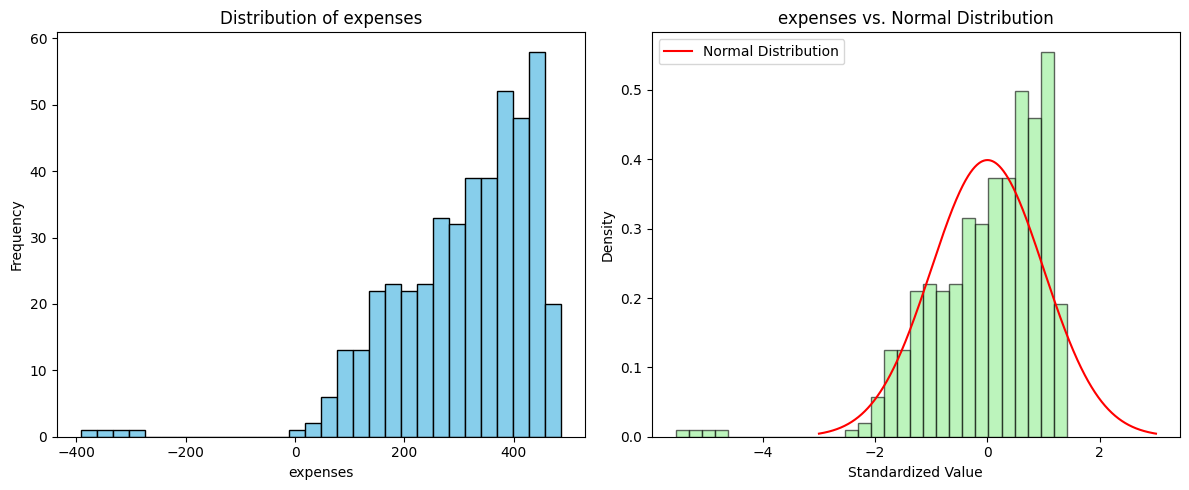

In [9]:
from scipy.stats import norm

for col in quantitative_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  
    ax[0].hist(data[col], bins=30, color='skyblue', edgecolor='black')
    ax[0].set_title(f'Distribution of {col}')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Frequency')

    normalized_data = (data[col] - data[col].mean()) / data[col].std()
    ax[1].hist(normalized_data, bins=30, density=True, alpha=0.6, color='lightgreen', edgecolor='black')
    x = np.linspace(-3, 3, 1000)  
    ax[1].plot(x, norm.pdf(x), 'r-', label='Normal Distribution')  
    ax[1].set_title(f'{col} vs. Normal Distribution')
    ax[1].set_xlabel('Standardized Value')
    ax[1].set_ylabel('Density')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [10]:
from scipy.stats import kstest

for col in quantitative_cols:
    standardized_data = (data[col] - data[col].mean()) / data[col].std()
    
    ks_stat, p_value = kstest(standardized_data, 'norm')
    
    print(f"Kolmogorov-Smirnov Test for {col}:")
    print(f"  KS Statistic: {ks_stat:.4f}")
    print(f"  P-value: {p_value:.4e}")
    if p_value < 0.05:
        print("  Result: Reject the null hypothesis (data does not follow a normal distribution)\n")
    else:
        print("  Result: Fail to reject the null hypothesis (data may follow a normal distribution)\n")


Kolmogorov-Smirnov Test for weight:
  KS Statistic: 0.0293
  P-value: 8.2278e-01
  Result: Fail to reject the null hypothesis (data may follow a normal distribution)

Kolmogorov-Smirnov Test for height:
  KS Statistic: 0.0585
  P-value: 8.8410e-02
  Result: Fail to reject the null hypothesis (data may follow a normal distribution)

Kolmogorov-Smirnov Test for cats:
  KS Statistic: 0.1748
  P-value: 1.7113e-12
  Result: Reject the null hypothesis (data does not follow a normal distribution)

Kolmogorov-Smirnov Test for age:
  KS Statistic: 0.0532
  P-value: 1.5095e-01
  Result: Fail to reject the null hypothesis (data may follow a normal distribution)

Kolmogorov-Smirnov Test for income:
  KS Statistic: 0.1849
  P-value: 6.0812e-14
  Result: Reject the null hypothesis (data does not follow a normal distribution)

Kolmogorov-Smirnov Test for savings:
  KS Statistic: 0.1542
  P-value: 8.3221e-10
  Result: Reject the null hypothesis (data does not follow a normal distribution)

Kolmogorov-

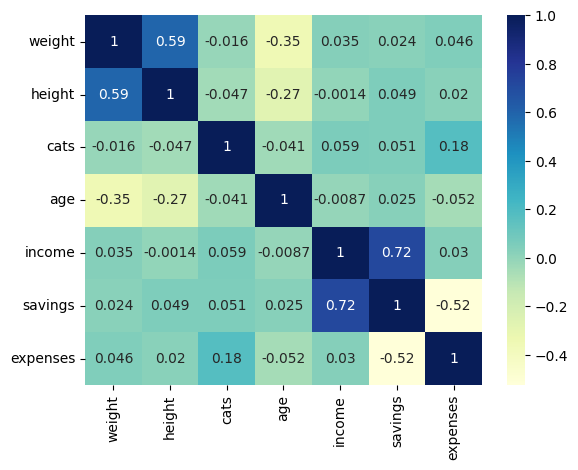

In [11]:
corr = data[quantitative_cols].corr()

dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True)

In [12]:
from scipy.stats import pearsonr

def test_dependencies(col1, col2, data=data):
    corr, p_value = pearsonr(data[col1], data[col2])
    return p_value


In [13]:
weight_height_dependency = test_dependencies('weight', 'height')
savings_income_dependency = test_dependencies('savings', 'income')
savings_expenses_dependency = test_dependencies('savings', 'expenses')
weight_age_dependency = test_dependencies('weight', 'age')
height_age_dependency = test_dependencies('height', 'age')

weight_height_dependency, savings_income_dependency, savings_expenses_dependency, weight_age_dependency, height_age_dependency

(8.853941613400061e-44,
 4.615995610331051e-72,
 4.5332813064907994e-33,
 4.4554635126028975e-14,
 7.57048617964054e-09)

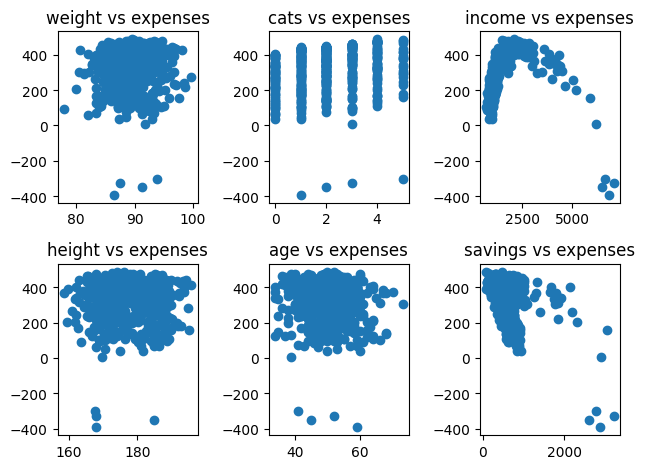

In [14]:
fig, ax = plt.subplots(2, 3)
i = 0
j = 0
for col in quantitative_cols:
    if col != 'expenses':
        ax[i, j].scatter(data[col], data['expenses'])
        ax[i, j].set_title(col+' vs expenses')
        i += 1
        if i > 1:
            i = 0
            j += 1

plt.tight_layout()

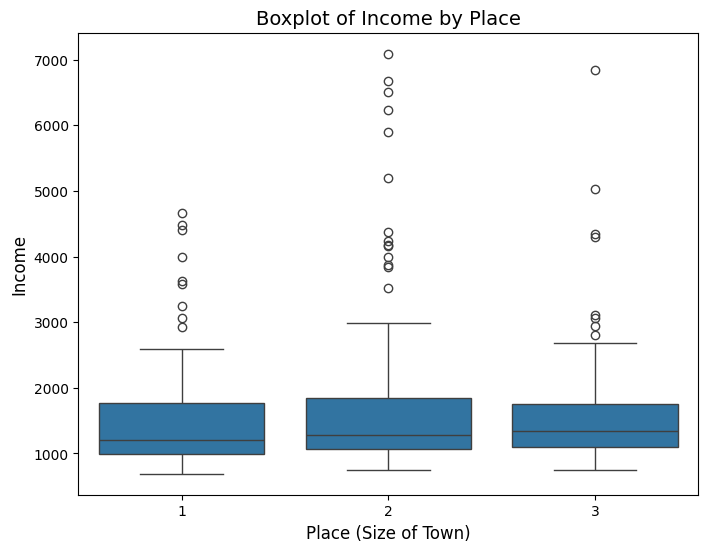

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='place', y='income')
plt.title('Boxplot of Income by Place', fontsize=14)
plt.xlabel('Place (Size of Town)', fontsize=12)
plt.ylabel('Income', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['1', '2', '3'])
plt.show()

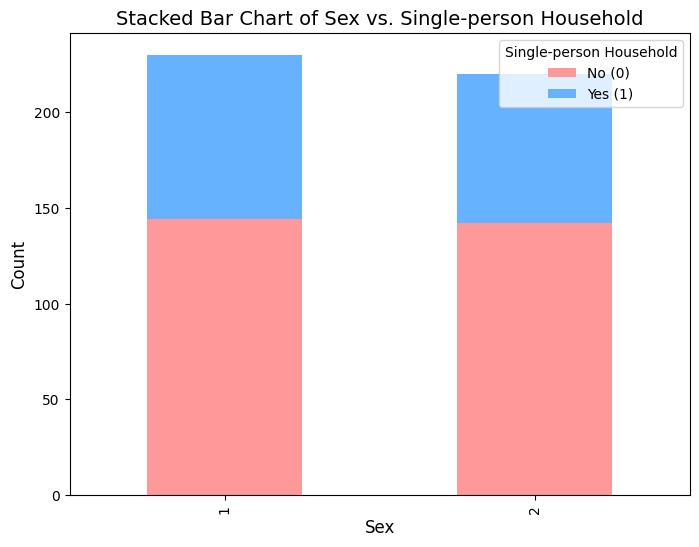

In [16]:
crosstab = pd.crosstab(data['sex'], data['single'])

crosstab.plot(kind='bar', stacked=True, color=['#FF9999', '#66B2FF'], figsize=(8, 6))
plt.title('Stacked Bar Chart of Sex vs. Single-person Household', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Single-person Household', labels=['No (0)', 'Yes (1)'])
plt.show()

In [17]:
data['wealth_class'] = 0
data.loc[data['income'] > data.income.quantile(0.25), 'wealth_class'] = 1
data.loc[data['income'] > data.income.quantile(0.75), 'wealth_class'] = 2
data.loc[data['income'] > data.income.quantile(0.9), 'wealth_class'] = 3

In [18]:
result = data.groupby('wealth_class')[['expenses']].agg([
    'mean',
    'std',
    ('q25', lambda x: np.percentile(x, 25)),
    ('q50', lambda x: np.percentile(x, 50)),
    ('q75', lambda x: np.percentile(x, 75)),
    'count',
])

result

expenses                                              
                    mean         std      q25      q50       q75 count
wealth_class                                                          
0             180.490000   72.818133  124.110  169.210  237.9500   113
1             341.325670   77.743135  290.375  352.945  395.9400   224
2             424.362353   34.799533  414.005  431.760  443.8175    68
3             294.569333  218.978376  301.950  368.700  408.7700    45

## Task 5

### a

In [19]:
women_savings = data.loc[data['sex']==1, 'savings']
men_savings = data.loc[data['sex']==2, 'savings']

import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(women_savings, men_savings, equal_var=False, alternative='less') #H_0 women save more

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -0.6502094472378092
P-value: 0.2579451345652113


There is no evidence to reject the null hypothesis that women earn more.

### b

In [20]:
data['expense_div_income'] = data['expenses'] / data['income']

model = sm.OLS(data['savings'], sm.add_constant(data[['expense_div_income']]))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                savings   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     654.7
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           1.17e-89
Time:                        22:05:07   Log-Likelihood:                -3149.2
No. Observations:                 450   AIC:                             6302.
Df Residuals:                     448   BIC:                             6311.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1585.2216     39.744     39.886      0.000    1507.113    1663.330
expense_div_income -4447.1743    173.810    -25.586      0.000   -4788.758   -4105.591
==============================================================================
Omnibus:                      159.267   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              892.681
Skew:                           1.420   Prob(JB):                    1.43e-194
Kurtosis:                       9.289   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### c

In [21]:
from scipy.stats import ttest_1samp

women_weights = data.loc[data['sex']==1, 'weight']

t_stat, p_value = ttest_1samp(women_weights, popmean=56, alternative='greater')

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 181.9430403811302
P-value: 5.690297645681283e-250


We have to reject the null hypothesis that the mean value is smaller than 56, which means, that the mean weight is bigger.

### d

We test whether wight is a normal distribution with mean 90 and std 3.6

In [22]:
from scipy.stats import chisquare, norm

weights = data['weight']

mean_weight = 90
std_weight = 3.6

num_bins = 10
bin_edges = np.linspace(weights.min(), weights.max(), num_bins + 1)

observed_freq, _ = np.histogram(weights, bins=bin_edges)

cdf_values = norm.cdf(bin_edges, loc=mean_weight, scale=std_weight)
expected_prob = np.diff(cdf_values)  # Probabilities for each bin
expected_freq = expected_prob * len(weights)

# Ensure the expected frequencies sum to the observed frequencies
expected_freq *= observed_freq.sum() / expected_freq.sum()

# Step 5: Perform the Chi-Square Test
chi_square_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)

# Output results
print("Chi-Square Statistic:", chi_square_stat)
print("p-value:", p_value)

# Conclusion
if p_value < 0.05:
    print("Reject the null hypothesis: The data does not follow a normal distribution.")
else:
    print("Fail to reject the null hypothesis: The data follows a normal distribution.")


Chi-Square Statistic: 19.639412294276845
p-value: 0.02027289635565944
Reject the null hypothesis: The data does not follow a normal distribution.


In [23]:
dummies = pd.get_dummies(data['place'], drop_first=True) * 1
dummies.columns = ['place_' + str(col) for col in dummies.columns]

df = data.drop(['place', 'wealth_class', 'expense_div_income'], axis=1).join(dummies)

In [24]:
y = df['expenses']
X = df.drop('expenses', axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               expenses   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     88.83
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           6.92e-99
Time:                        22:05:07   Log-Likelihood:                -2566.0
No. Observations:                 450   AIC:                             5154.
Df Residuals:                     439   BIC:                             5199.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -71.2740    161.791     -0.441      0.660    -389.254     246.706
weight         0.5084      1.353      0.376      0.707      -2.150       3.167
height         1.9770      0.730      2.707      0.007       0.542       3.412
sex          -15.1329     12.483     -1.212      0.226     -39.667       9.401
cats          18.1933      2.539      7.166      0.000      13.203      23.183
age            0.1855      0.544      0.341      0.733      -0.883       1.254
income         0.0831      0.009      9.481      0.000       0.066       0.100
savings       -0.3041      0.015    -19.627      0.000      -0.335      -0.274
single        48.9816     11.944      4.101      0.000      25.507      72.456
place_2       -4.6089      8.753     -0.527      0.599     -21.811      12.593
place_3        3.0926      9.675      0.320      0.749     -15.923      22.108
==============================================================================
Omnibus:                      193.277   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2633.113
Skew:                          -1.463   Prob(JB):                         0.00
Kurtosis:                      14.483   Cond. No.                     9.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
X_np = np.asarray(X)
y_np = np.asarray(y)

model = sm.OLS(y_np, X_np)
results = model.fit()
sm.stats.diagnostic.linear_reset(results, power=2, test_type='fitted')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=68.14635937637814, p-value=1.5179948105525304e-16, df_denom=1>

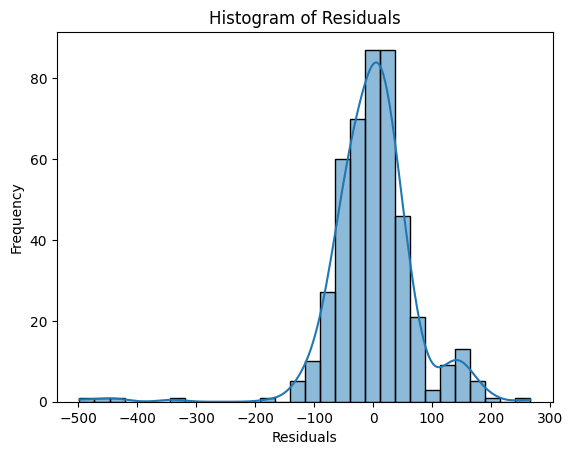

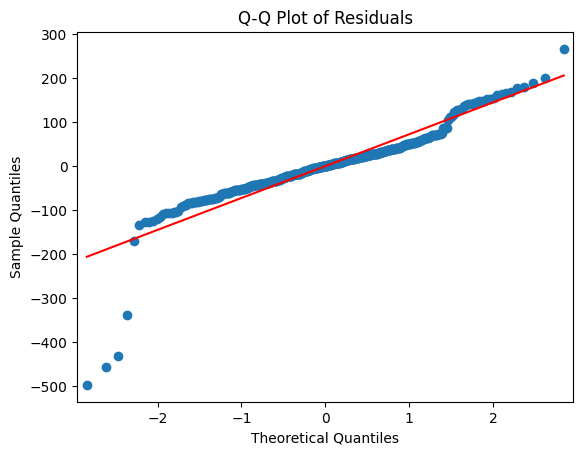

Shapiro-Wilk Test Statistic: 0.8597885370254517, p-value: 1.20602855762049e-19
Residuals do not appear to follow a normal distribution (reject H0).


In [26]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# Plot Histogram of Residuals
resids = results.resid
sns.histplot(resids, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
qqplot(resids, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(resids)
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, p-value: {shapiro_p}")

# Conclusion
if shapiro_p > 0.05:
    print("Residuals appear to follow a normal distribution (fail to reject H0).")
else:
    print("Residuals do not appear to follow a normal distribution (reject H0).")


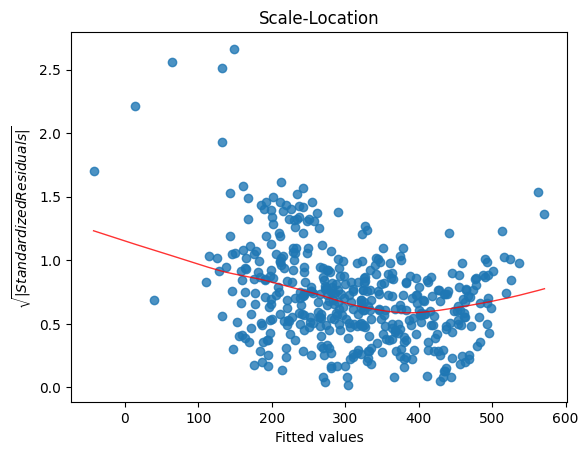

In [27]:
from statsmodels.graphics.gofplots import ProbPlot

# model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

plot_lm_2 = plt.figure()
sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt,
            scatter=True,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_2.axes[0].set_title('Scale-Location')
plot_lm_2.axes[0].set_xlabel('Fitted values')
plot_lm_2.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

#calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

    feature          VIF
0     const  2187.516701
1    weight     1.978396
2    height     2.787977
3       sex     3.254002
4      cats     1.012013
5       age     1.156301
6    income     5.663402
7   savings     3.464390
8    single     2.761475
9   place_2     1.597357
10  place_3     1.592299


In [29]:
df['const'] = 1
df['income_2'] = df['income'] ** 2
df['income_3'] = df['income'] ** 3
df['savings_div_income'] = df['savings'] / df['income']
df['bmi'] = df['weight'] / df['height'] ** 2

In [128]:
qualitative_cols

['sex', 'single', 'place']

In [142]:
for col in dummies.columns[2:3]:
    df_test = df.loc[df[col]==1].copy()
    fit = np.polyfit(df_test['disposable_income'], df_test['expenses'], deg=2)
    df_test['fitted'] = fit[0] * df_test['disposable_income'] ** 2 + fit[1] * df_test['disposable_income'] + fit[2]
    df_test['error'] = (df_test['fitted'] / df_test['expenses']) - 1

df_test.sort_values('error')[:20]

,weight,height,sex,cats,age,income,savings,single,expenses,place_2,...,disposable_x_2_cats,disposable_2_x_2_cats,disposable_x_3_cats,disposable_2_x_3_cats,disposable_x_4_cats,disposable_2_x_4_cats,disposable_x_5_cats,disposable_2_x_5_cats,fitted,error
id,,,,,,,,,,,,,,,,,,,,,
36,88.48,184.81,2,2,41,946.28,900.72,0,75.64,0,...,45.56,2.075714e+03,0.0,0.0,0.0,0.0,0.0,0.0,72.579986,-0.040455
152,84.31,171.73,1,2,54,866.86,748.36,0,110.40,1,...,118.50,1.404225e+04,0.0,0.0,0.0,0.0,0.0,0.0,106.119803,-0.038770
129,93.20,183.16,2,2,44,1002.10,708.19,0,185.84,0,...,293.91,8.638309e+04,0.0,0.0,0.0,0.0,0.0,0.0,180.236341,-0.030153
62,85.06,167.91,1,2,34,4404.13,1926.37,1,337.92,0,...,2477.76,6.139295e+06,0.0,0.0,0.0,0.0,0.0,0.0,329.276505,-0.025579
378,94.44,181.65,2,2,55,691.73,577.74,0,106.65,0,...,113.99,1.299372e+04,0.0,0.0,0.0,0.0,0.0,0.0,104.092326,-0.023982
389,82.18,174.45,1,2,61,987.16,358.36,0,302.60,0,...,628.80,3.953894e+05,0.0,0.0,0.0,0.0,0.0,0.0,296.075507,-0.021561
421,93.15,186.66,2,2,45,1183.60,716.61,0,249.18,0,...,466.99,2.180797e+05,0.0,0.0,0.0,0.0,0.0,0.0,244.310714,-0.019541
242,90.45,187.77,2,2,49,1177.32,773.11,0,226.18,1,...,404.21,1.633857e+05,0.0,0.0,0.0,0.0,0.0,0.0,222.109363,-0.017997
175,88.03,182.96,2,2,43,1317.78,605.95,0,325.21,1,...,711.83,5.067019e+05,0.0,0.0,0.0,0.0,0.0,0.0,319.584929,-0.017297


In [80]:
df['single_income'] = (df['single'] == 0) * df['income']
df['single_savings'] = (df['single'] == 0) * df['savings']

df['disposable_income'] = df['income'] - df['savings']
df['disposable_income_2'] = (df['income'] - df['savings']) ** 2

In [ ]:
dummies = pd.get_dummies(df['cats']) * 1
dummies.columns = [str(col) + '_cats' for col in dummies.columns]
dummies.head()
df = df.join(dummies)

In [107]:
for col in dummies:
    df[f'disposable_x_{col}'] = df['disposable_income'] * df[col]
    df[f'disposable_2_x_{col}'] = df['disposable_income_2'] * df[col]

In [ ]:
columns = [
    'const', 
    'disposable_x_0_cats', 
    'disposable_2_x_0_cats', 
    'disposable_x_1_cats',
    'disposable_2_x_1_cats', 
    'disposable_x_2_cats', 
    'disposable_2_x_2_cats',
    'disposable_x_3_cats', 
    'disposable_2_x_3_cats', 
    'disposable_x_4_cats',
    'disposable_2_x_4_cats', 
    'disposable_x_5_cats',
    'disposable_2_x_5_cats'
]


In [122]:
y = df['expenses']
X = df[columns]

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               expenses   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     5577.
Date:                Sat, 30 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:33:14   Log-Likelihood:                -1681.4
No. Observations:                 450   AIC:                             3389.
Df Residuals:                     437   BIC:                             3442.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    54.6501      1.191     45.894      0.000      52.310      56.990
disposable_x_0_cats       0.4090      0.004    110.995      0.000       0.402       0.416
disposable_2_x_0_cats    -0.0001    1.7e-06    -74.338      0.000      -0.000      -0.000
disposable_x_1_cats       0.4717      0.003    181.408      0.000       0.467       0.477
disposable_2_x_1_cats    -0.0001   1.07e-06   -136.975      0.000      -0.000      -0.000
disposable_x_2_cats       0.4790      0.002    195.694      0.000       0.474       0.484
disposable_2_x_2_cats    -0.0001   9.77e-07   -152.184      0.000      -0.000      -0.000
disposable_x_3_cats       0.5022      0.003    185.362      0.000       0.497       0.508
disposable_2_x_3_cats    -0.0002   1.05e-06   -148.366      0.000      -0.000      -0.000
disposable_x_4_cats       0.5514      0.004    143.312      0.000       0.544       0.559
disposable_2_x_4_cats    -0.0002   1.79e-06    -95.801      0.000      -0.000      -0.000
disposable_x_5_cats       0.5471      0.004    124.778      0.000       0.538       0.556
disposable_2_x_5_cats    -0.0002   1.44e-06   -114.384      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       53.470   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              343.044
Skew:                           0.203   Prob(JB):                     3.23e-75
Kurtosis:                       7.258   Cond. No.                     3.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:
df['resids'] = results.resid

df.corr()['resids'].sort_values()

0_cats                  -2.530070e-01
1_cats                  -9.648040e-02
age                     -4.629837e-02
2_cats                  -3.555734e-02
savings                 -2.981117e-02
savings_div_income      -2.507113e-02
income                  -1.318448e-02
single_savings          -7.235496e-03
single_sabings          -7.235496e-03
income_2                -7.229997e-03
disposable_2_x_5_cats   -1.650380e-11
disposable_x_5_cats     -1.528669e-11
disposable_2_x_3_cats   -2.580236e-12
disposable_x_3_cats     -2.148240e-12
disposable_x_0_cats     -1.048933e-12
disposable_income_2     -7.129997e-14
disposable_2_x_0_cats    4.949447e-14
disposable_2_x_2_cats    2.377156e-13
disposable_x_2_cats      1.101509e-12
disposable_income        1.401582e-12
disposable_x_4_cats      2.972388e-12
disposable_2_x_4_cats    3.155708e-12
disposable_x_1_cats      9.321725e-12
disposable_2_x_1_cats    1.193581e-11
single                   1.701097e-03
income_3                 2.056241e-03
bmi         

In [123]:
X_np = np.asarray(X)
y_np = np.asarray(y)

model = sm.OLS(y_np, X_np)
results = model.fit()
sm.stats.diagnostic.linear_reset(results, power=2, test_type='fitted')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=0.8625393507059719, p-value=0.3530290467321274, df_denom=1>

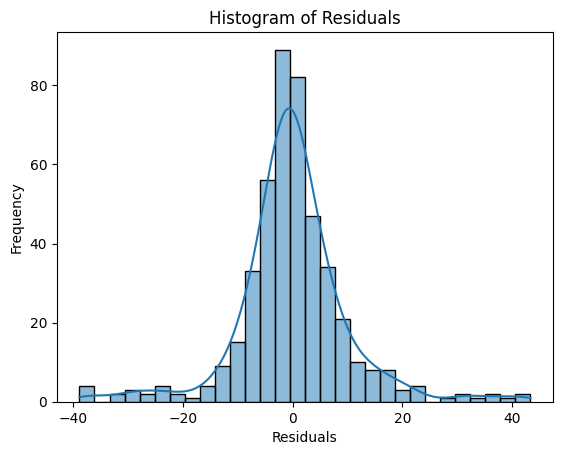

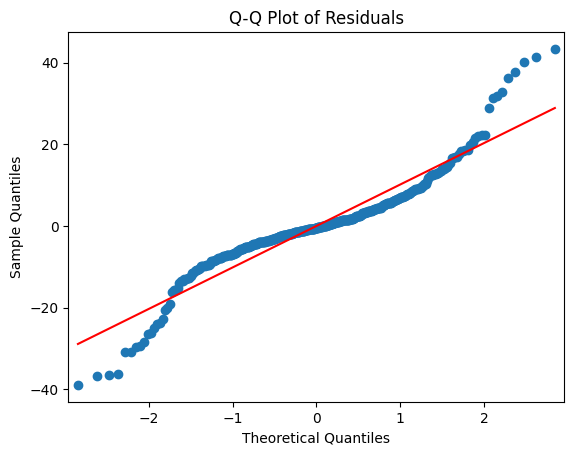

Shapiro-Wilk Test Statistic: 0.9026244878768921, p-value: 2.321323967499156e-16
Residuals do not appear to follow a normal distribution (reject H0).


In [124]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# Plot Histogram of Residuals
resids = results.resid
sns.histplot(resids, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
qqplot(resids, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(resids)
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, p-value: {shapiro_p}")

# Conclusion
if shapiro_p > 0.05:
    print("Residuals appear to follow a normal distribution (fail to reject H0).")
else:
    print("Residuals do not appear to follow a normal distribution (reject H0).")


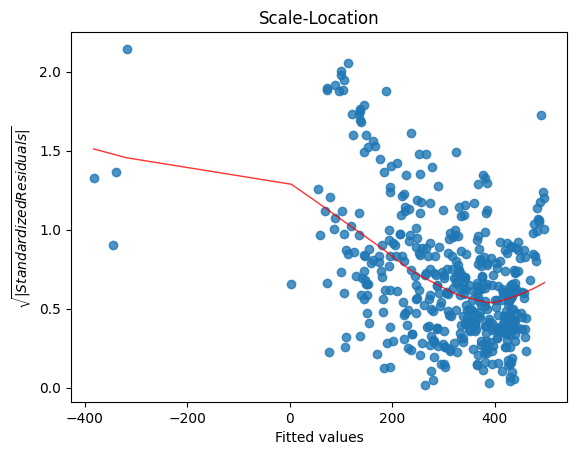

In [119]:
from statsmodels.graphics.gofplots import ProbPlot

# model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

plot_lm_2 = plt.figure()
sns.regplot(x=model_fitted_y, y=model_norm_residuals_abs_sqrt,
            scatter=True,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_2.axes[0].set_title('Scale-Location')
plot_lm_2.axes[0].set_xlabel('Fitted values')
plot_lm_2.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

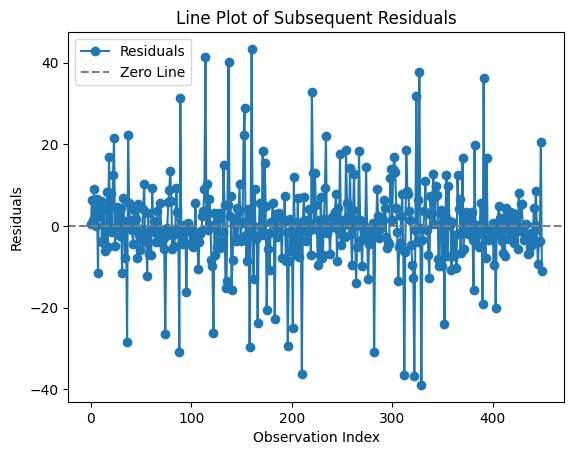

In [120]:
# put your code here
import matplotlib.pyplot as plt

# Assuming `results` contains the fitted regression model
residuals = results.resid  # Extract residuals

# Line plot of subsequent residuals
plt.plot(residuals, marker='o', linestyle='-', label='Residuals')
plt.axhline(y=0, color='gray', linestyle='--', label='Zero Line')
plt.title("Line Plot of Subsequent Residuals")
plt.xlabel("Observation Index")
plt.ylabel("Residuals")
plt.legend()
plt.show()

